#### Imports & Downloads

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score

import vector_functions

### Model Preparation

#### Functions

In [15]:
def print_target_distribution(df, colname):
    positive = np.count_nonzero(df[colname] == 1)
    negative = np.count_nonzero(df[colname] == 0)
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [16]:
evaluation = pd.DataFrame(
    columns=["model", "tuning", "vec_variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [17]:
def add_to_eval_df(model, model_name, tuning, vec_variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, tuning, vec_variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [18]:
def evaluate_model(model, x_test, y_test):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### Data Import

In [19]:
df_train_cleaned = pd.read_csv("..\\..\\..\\data\\new_datasets\\train_cleaned.csv")

In [20]:
print_target_distribution(df_train_cleaned, 'label')

- Positive: 13103
- Negative: 48155
- Verhältnis: 3.6751125696405404


In [21]:
df_train_cleaned = df_train_cleaned[df_train_cleaned.tweet_cleaned.notna()]
df_train_cleaned.isna().sum()

Unnamed: 0           0
tweet                0
label                0
tweet_cleaned        0
user_handle          0
hashtags             0
emojis           58161
dtype: int64

#### Vectorize - Word2Vec

In [22]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v, w2v_model = vector_functions.vectorize_word2vec(df=df_train_cleaned,
                                                                                                  text_column="tweet_cleaned",
                                                                                                  label_column="label")

#### Vectorize - TF-IDF

In [23]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf, tf_model = vector_functions.vectorize_tfidf(df=df_train_cleaned,
                                                                                          text_column="tweet_cleaned",
                                                                                          label_column="label")

#### Vectorize - Glove

In [24]:
glove_path = "./glove/glove.twitter.27B.100d.txt"
X_train_gl, X_test_gl, y_train_gl, y_test_gl, gl_model = vector_functions.vectorize_glove(df=df_train_cleaned,
                                                                                          glove_path=glove_path,
                                                                                          text_column="tweet_cleaned",
                                                                                          label_column="label")

### Training Functions

In [25]:
def cross_validate_model(model, x_data, y_data, cv=10, scoring='f1'):
    cv = cross_val_score(model, x_data, y_data, cv=cv, scoring=scoring, verbose=10)
    print(f" MEAN: {np.mean(cv)}")

    return cv

#### 1.1 Bagging

##### 1.1.1 RandomForest

In [26]:
def train_randomforest(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [27]:
def train_randomforest_tuned_randsearch(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
    model.fit(x_data, y_data)

    return model

In [28]:
def train_randomforest_tuned_optuna(x_data, y_data):
    model = RandomForestClassifier(n_jobs=-1, n_estimators=450, max_depth=55, min_samples_split=4, min_samples_leaf=1)
    model.fit(x_data, y_data)

    return model

##### 1.1.2 BalancedRandomForest untuned

In [29]:
def train_balancedrandomforest(x_data, y_data):
    model = BalancedRandomForestClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [30]:
# def train_balancedrandomforest_tuned(x_data, y_data):
#     model = BalancedRandomForestClassifier(n_jobs=-1, max_depth=9, max_features=None, max_leaf_nodes=13)
#     model.fit(x_data, y_data)
#
#     return model

#### 1.2 Boosting

##### 1.2.1 XGBClassifier

In [31]:
def train_xgboost(x_data, y_data):
    model = XGBClassifier(n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [32]:
def train_xgboost_tuned_gridsearch(x_data, y_data):
    model = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
    model.fit(x_data, y_data)

    return model

In [33]:
def train_xgboost_tuned_randsearch(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, subsample=0.5, reg_alpha=1, n_estimators=150, min_child_weight=1,
                          max_depth=7, learning_rate=0.1, gamma=0.4)
    model.fit(x_data, y_data)

    return model

In [34]:
def train_xgboost_tuned_optuna(x_data, y_data):
    model = XGBClassifier(n_jobs=-1, boost='gblinear', subsample=0.4736419905302216,
                          colsample_bytree=0.6711055768358083, alpha=8.528933855762793e-06)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 CatBoostClassifier

In [35]:
def train_catboost(x_data, y_data):
    model = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
    model.fit(x_data, y_data)

    return model

##### 1.2.1 LGBMClassifier

In [36]:
def train_lightgbm(x_data, y_data):
    model = LGBMClassifier()
    model.fit(x_data, y_data)

    return model

#### 1.3 Stacking

##### 1.3.1 Stacking: RandomForest + LinearSVC

In [37]:
def train_stacking_rf_svm(x_data, y_data):
    base_models = [
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', LinearSVC(random_state=42))
    ]
    model = StackingClassifier(estimators=base_models, n_jobs=-1)
    model.fit(x_data, y_data)

    return model

In [38]:
def train_svc(x_data, y_data):
    model = LinearSVC()
    model.fit(x_data, y_data)

    return model

### Model Training

#### W2V

model accuracy for classification is = 79.81%
------------------------------------------------
Confusion Matrix:
       0    1
0  14039  420
1   3290  629
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     14459
           1       0.60      0.16      0.25      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.57      0.57     18378
weighted avg       0.77      0.80      0.75     18378



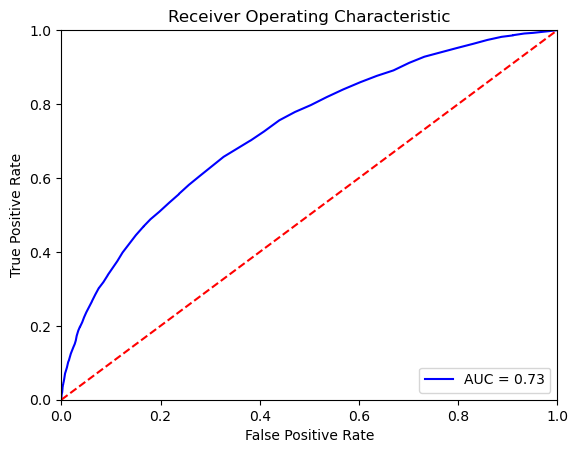

In [39]:
rf_untuned_w2v = train_randomforest(X_train_w2v, y_train_w2v)
evaluate_model(rf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_untuned_w2v, "RandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 79.26%
------------------------------------------------
Confusion Matrix:
       0    1
0  14292  167
1   3645  274
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.88     14459
           1       0.62      0.07      0.13      3919

    accuracy                           0.79     18378
   macro avg       0.71      0.53      0.50     18378
weighted avg       0.76      0.79      0.72     18378



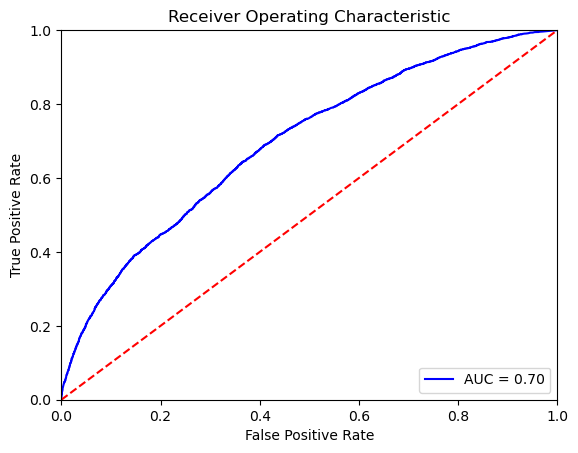

In [40]:
rf_rand_w2v = train_randomforest_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(rf_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_rand_w2v, "RandomForest", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.07%
------------------------------------------------
Confusion Matrix:
       0    1
0  14080  379
1   3283  636
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     14459
           1       0.63      0.16      0.26      3919

    accuracy                           0.80     18378
   macro avg       0.72      0.57      0.57     18378
weighted avg       0.77      0.80      0.75     18378



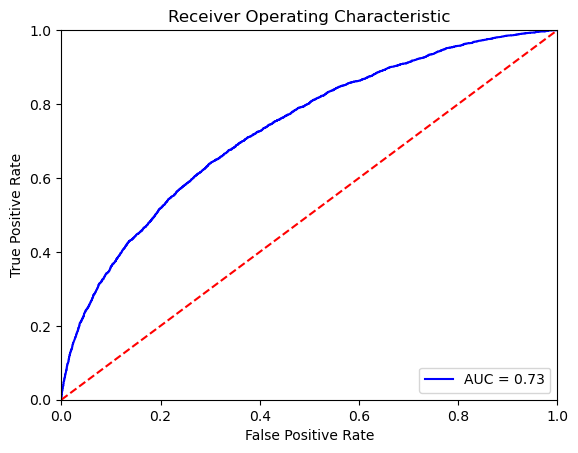

In [41]:
rf_optuna_w2v = train_randomforest_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(rf_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(rf_optuna_w2v, "RandomForest", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 68.32%
------------------------------------------------
Confusion Matrix:
       0     1
0  10024  4435
1   1388  2531
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.69      0.77     14459
           1       0.36      0.65      0.47      3919

    accuracy                           0.68     18378
   macro avg       0.62      0.67      0.62     18378
weighted avg       0.77      0.68      0.71     18378



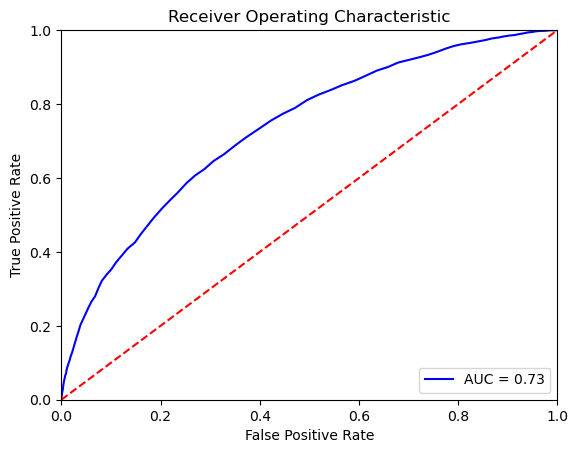

In [42]:
brf_untuned_w2v = train_balancedrandomforest(X_train_w2v, y_train_w2v)
evaluate_model(brf_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(brf_untuned_w2v, "BalancedRandomForest", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 79.32%
------------------------------------------------
Confusion Matrix:
       0    1
0  13710  749
1   3051  868
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     14459
           1       0.54      0.22      0.31      3919

    accuracy                           0.79     18378
   macro avg       0.68      0.58      0.60     18378
weighted avg       0.76      0.79      0.76     18378



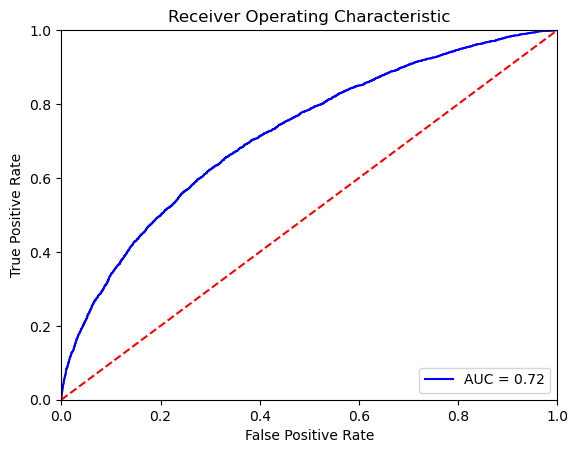

In [43]:
xgb_untuned_w2v = train_xgboost(X_train_w2v, y_train_w2v)
evaluate_model(xgb_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_untuned_w2v, "XGBoost", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 79.91%
------------------------------------------------
Confusion Matrix:
       0    1
0  13813  646
1   3046  873
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     14459
           1       0.57      0.22      0.32      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.59      0.60     18378
weighted avg       0.77      0.80      0.76     18378



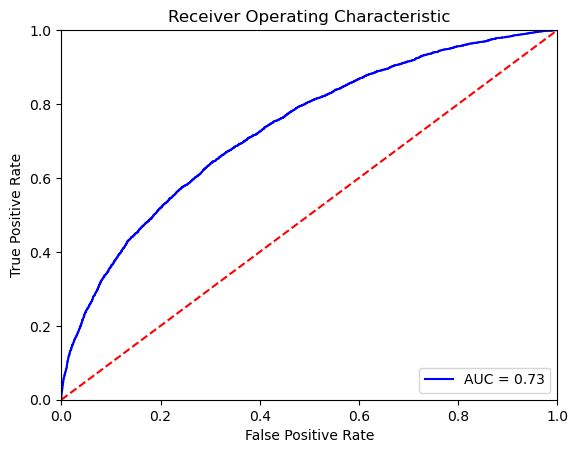

In [44]:
xgb_grid_w2v = train_xgboost_tuned_gridsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_grid_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_grid_w2v, "XGBoost", "gridsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.15%
------------------------------------------------
Confusion Matrix:
       0    1
0  13812  647
1   3001  918
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88     14459
           1       0.59      0.23      0.33      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.59      0.61     18378
weighted avg       0.77      0.80      0.77     18378



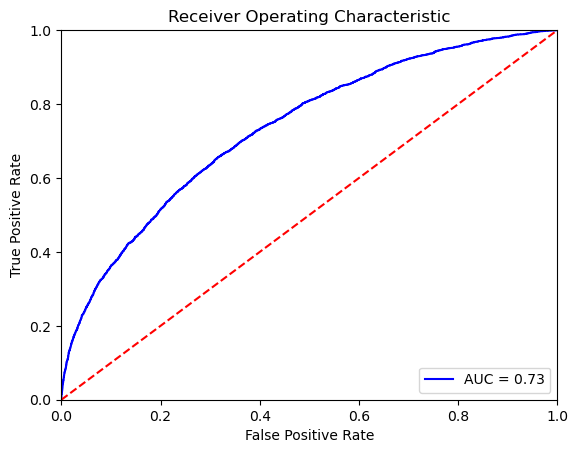

In [45]:
xgb_rand_w2v = train_xgboost_tuned_randsearch(X_train_w2v, y_train_w2v)
evaluate_model(xgb_rand_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_rand_w2v, "XGBoost", "randsearch", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:23:53] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 78.41%
------------------------------------------------
Confusion Matrix:
       0     1
0  13436  1023
1   2944   975
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     14459
           1       0.49      0.25      0.33      3919

    accuracy                           0.78     18378
   macro avg       0.65      0.59      0.60     18378
weighted avg       0.75      0.78      0.76     18378



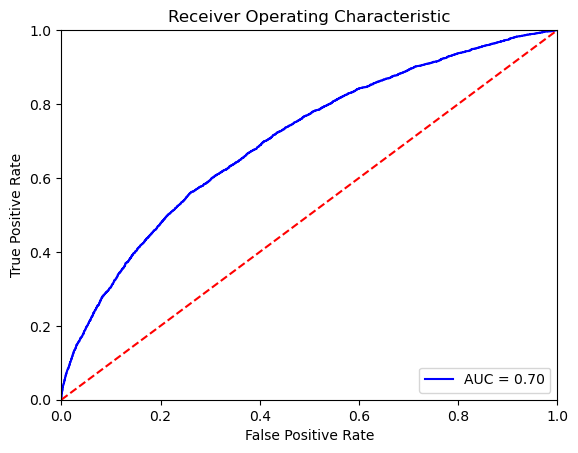

In [46]:
xgb_optuna_w2v = train_xgboost_tuned_optuna(X_train_w2v, y_train_w2v)
evaluate_model(xgb_optuna_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(xgb_optuna_w2v, "XGBoost", "optuna", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

0:	learn: 0.6522426	total: 252ms	remaining: 25s
1:	learn: 0.6210840	total: 365ms	remaining: 17.9s
2:	learn: 0.5940418	total: 466ms	remaining: 15.1s
3:	learn: 0.5736952	total: 548ms	remaining: 13.2s
4:	learn: 0.5574221	total: 626ms	remaining: 11.9s
5:	learn: 0.5435345	total: 712ms	remaining: 11.2s
6:	learn: 0.5330364	total: 799ms	remaining: 10.6s
7:	learn: 0.5236563	total: 887ms	remaining: 10.2s
8:	learn: 0.5160556	total: 968ms	remaining: 9.79s
9:	learn: 0.5097241	total: 1.07s	remaining: 9.68s
10:	learn: 0.5040877	total: 1.17s	remaining: 9.51s
11:	learn: 0.4992490	total: 1.27s	remaining: 9.32s
12:	learn: 0.4954997	total: 1.39s	remaining: 9.29s
13:	learn: 0.4922854	total: 1.48s	remaining: 9.12s
14:	learn: 0.4893327	total: 1.59s	remaining: 9.04s
15:	learn: 0.4875743	total: 1.67s	remaining: 8.75s
16:	learn: 0.4853116	total: 1.79s	remaining: 8.75s
17:	learn: 0.4835800	total: 1.89s	remaining: 8.59s
18:	learn: 0.4821694	total: 1.97s	remaining: 8.41s
19:	learn: 0.4806145	total: 2.07s	remaining

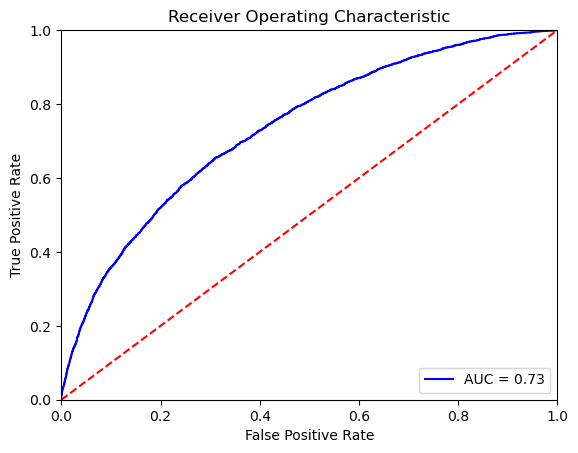

In [47]:
cat_untuned_w2v = train_catboost(X_train_w2v, y_train_w2v)
evaluate_model(cat_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(cat_untuned_w2v, "CatBoostClassifier", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 80.15%
------------------------------------------------
Confusion Matrix:
       0    1
0  14031  428
1   3220  699
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88     14459
           1       0.62      0.18      0.28      3919

    accuracy                           0.80     18378
   macro avg       0.72      0.57      0.58     18378
weight

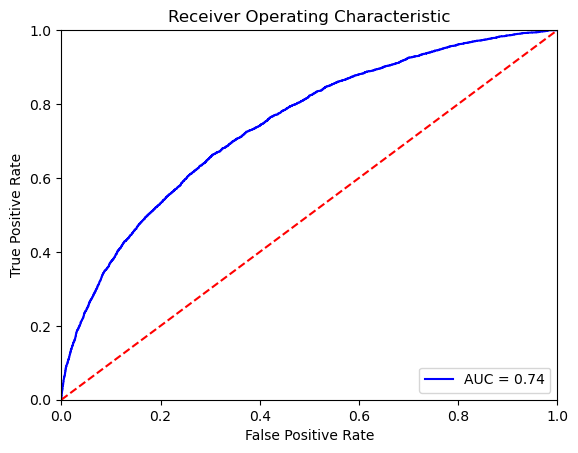

In [48]:
light_untuned_w2v = train_lightgbm(X_train_w2v, y_train_w2v)
evaluate_model(light_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(light_untuned_w2v, "LightGBM", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

model accuracy for classification is = 80.35%
------------------------------------------------
Confusion Matrix:
       0    1
0  13984  475
1   3137  782
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     14459
           1       0.62      0.20      0.30      3919

    accuracy                           0.80     18378
   macro avg       0.72      0.58      0.59     18378
weighted avg       0.78      0.80      0.76     18378



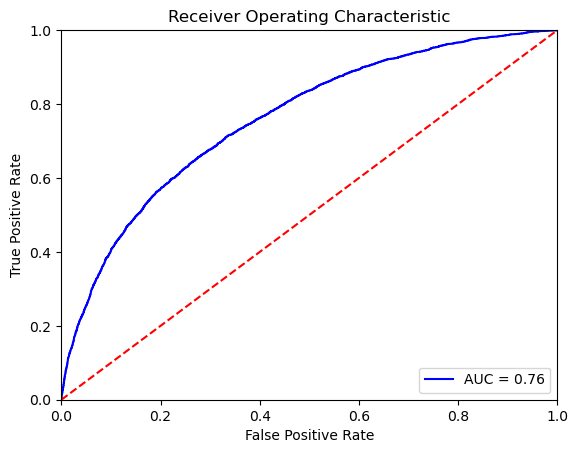

In [49]:
stack_untuned_w2v = train_stacking_rf_svm(X_train_w2v, y_train_w2v)
evaluate_model(stack_untuned_w2v, X_test_w2v, y_test_w2v)
add_to_eval_df(stack_untuned_w2v, "StackingClassifier-RF-SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

In [50]:
svc_untuned_w2v = train_svc(X_train_w2v, y_train_w2v)
add_to_eval_df(svc_untuned_w2v, "SVC", "untuned", "w2v", X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### TF-IDF

model accuracy for classification is = 82.22%
------------------------------------------------
Confusion Matrix:
       0     1
0  13987   472
1   2795  1124
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14459
           1       0.70      0.29      0.41      3919

    accuracy                           0.82     18378
   macro avg       0.77      0.63      0.65     18378
weighted avg       0.81      0.82      0.79     18378



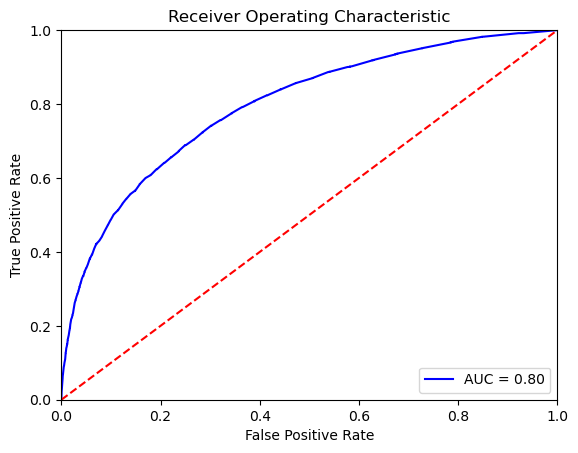

In [51]:
rf_untuned_tf = train_randomforest(X_train_tf, y_train_tf)
evaluate_model(rf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_untuned_tf, "RandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 81.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  13972   487
1   2894  1025
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89     14459
           1       0.68      0.26      0.38      3919

    accuracy                           0.82     18378
   macro avg       0.75      0.61      0.63     18378
weighted avg       0.80      0.82      0.78     18378



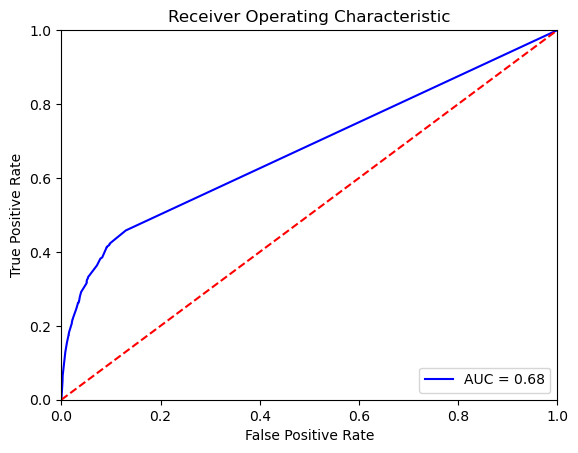

In [52]:
rf_rand_tf = train_randomforest_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(rf_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_rand_tf, "RandomForest", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 79.61%
------------------------------------------------
Confusion Matrix:
       0    1
0  14430   29
1   3719  200
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     14459
           1       0.87      0.05      0.10      3919

    accuracy                           0.80     18378
   macro avg       0.83      0.52      0.49     18378
weighted avg       0.81      0.80      0.72     18378



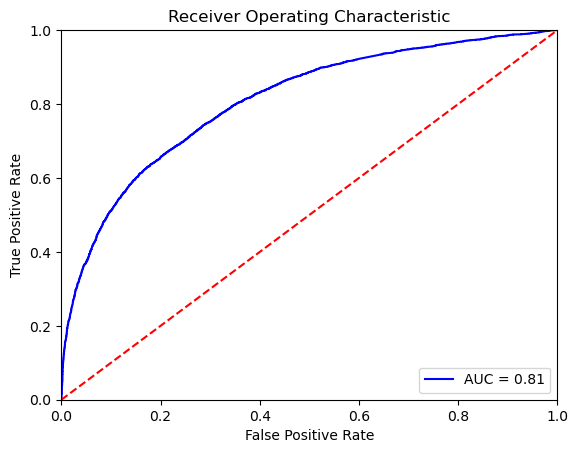

In [53]:
rf_optuna_tf = train_randomforest_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(rf_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(rf_optuna_tf, "RandomForest", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 74.46%
------------------------------------------------
Confusion Matrix:
       0     1
0  10894  3565
1   1128  2791
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     14459
           1       0.44      0.71      0.54      3919

    accuracy                           0.74     18378
   macro avg       0.67      0.73      0.68     18378
weighted avg       0.81      0.74      0.76     18378



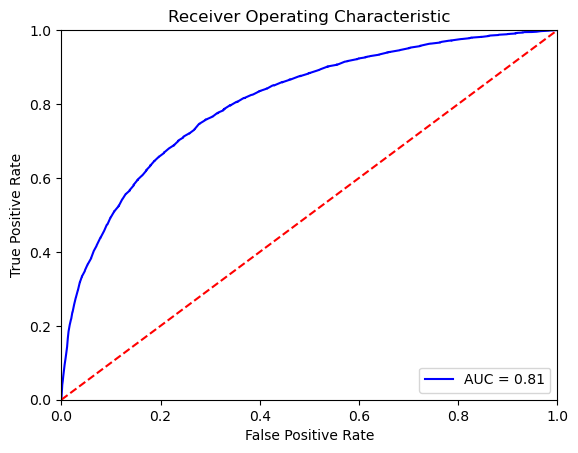

In [54]:
brf_untuned_tf = train_balancedrandomforest(X_train_tf, y_train_tf)
evaluate_model(brf_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(brf_untuned_tf, "BalancedRandomForest", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.77%
------------------------------------------------
Confusion Matrix:
       0     1
0  13998   461
1   2705  1214
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.31      0.43      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.64      0.67     18378
weighted avg       0.81      0.83      0.80     18378



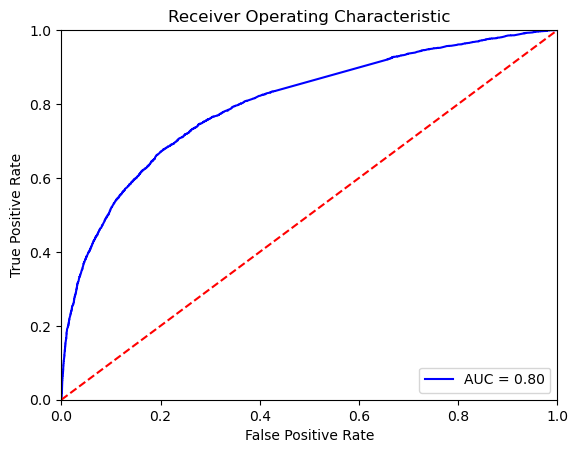

In [55]:
xgb_untuned_tf = train_xgboost(X_train_tf, y_train_tf)
evaluate_model(xgb_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_untuned_tf, "XGBoost", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.91%
------------------------------------------------
Confusion Matrix:
       0     1
0  13922   537
1   2604  1315
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.34      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.65      0.68     18378
weighted avg       0.81      0.83      0.80     18378



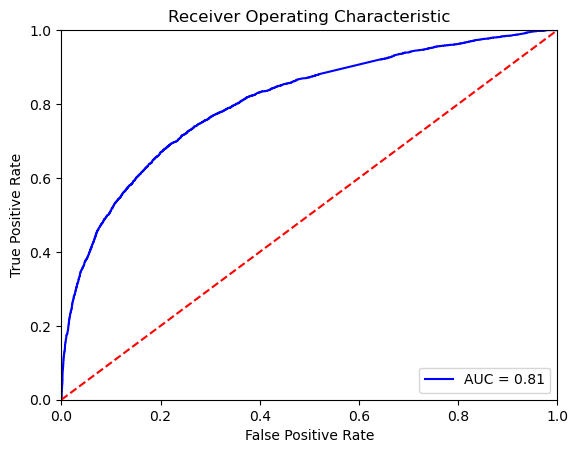

In [56]:
xgb_grid_tf = train_xgboost_tuned_gridsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_grid_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_grid_tf, "XGBoost", "gridsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  14017   442
1   2756  1163
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     14459
           1       0.72      0.30      0.42      3919

    accuracy                           0.83     18378
   macro avg       0.78      0.63      0.66     18378
weighted avg       0.81      0.83      0.80     18378



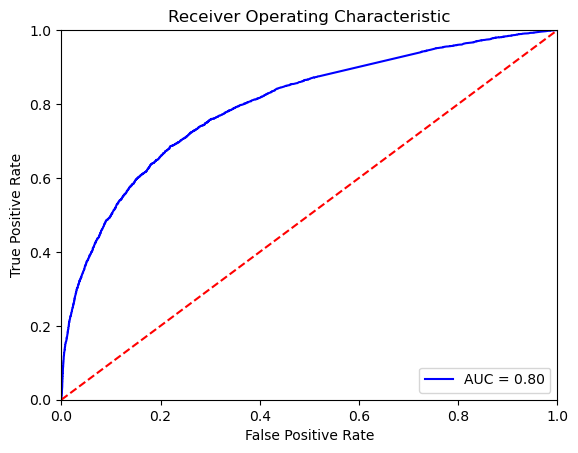

In [57]:
xgb_rand_tf = train_xgboost_tuned_randsearch(X_train_tf, y_train_tf)
evaluate_model(xgb_rand_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_rand_tf, "XGBoost", "randsearch", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:32:55] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 82.60%
------------------------------------------------
Confusion Matrix:
       0     1
0  13875   584
1   2613  1306
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.33      0.45      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.67     18378
weighted avg       0.81      0.83      0.80     18378



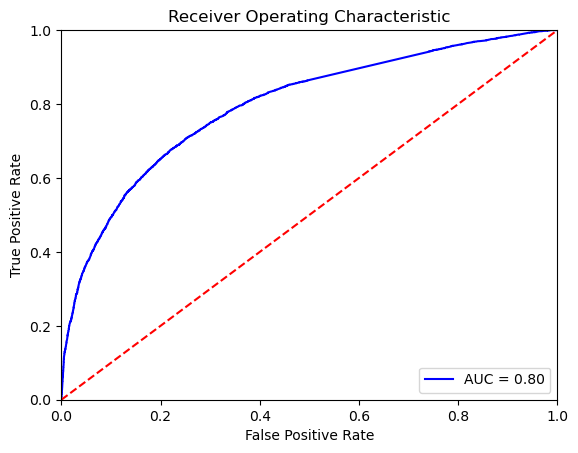

In [58]:
xgb_optuna_tf = train_xgboost_tuned_optuna(X_train_tf, y_train_tf)
evaluate_model(xgb_optuna_tf, X_test_tf, y_test_tf)
add_to_eval_df(xgb_optuna_tf, "XGBoost", "optuna", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

0:	learn: 0.6529031	total: 86ms	remaining: 8.52s
1:	learn: 0.6211461	total: 166ms	remaining: 8.16s
2:	learn: 0.5950023	total: 247ms	remaining: 8s
3:	learn: 0.5727107	total: 330ms	remaining: 7.92s
4:	learn: 0.5572375	total: 415ms	remaining: 7.89s
5:	learn: 0.5432046	total: 499ms	remaining: 7.82s
6:	learn: 0.5307686	total: 582ms	remaining: 7.73s
7:	learn: 0.5214806	total: 668ms	remaining: 7.68s
8:	learn: 0.5132130	total: 751ms	remaining: 7.59s
9:	learn: 0.5059916	total: 833ms	remaining: 7.49s
10:	learn: 0.5001601	total: 917ms	remaining: 7.42s
11:	learn: 0.4952050	total: 999ms	remaining: 7.32s
12:	learn: 0.4909213	total: 1.08s	remaining: 7.23s
13:	learn: 0.4875350	total: 1.16s	remaining: 7.14s
14:	learn: 0.4842737	total: 1.25s	remaining: 7.06s
15:	learn: 0.4815149	total: 1.33s	remaining: 6.97s
16:	learn: 0.4788510	total: 1.41s	remaining: 6.9s
17:	learn: 0.4765742	total: 1.5s	remaining: 6.83s
18:	learn: 0.4747001	total: 1.58s	remaining: 6.74s
19:	learn: 0.4729507	total: 1.66s	remaining: 6.

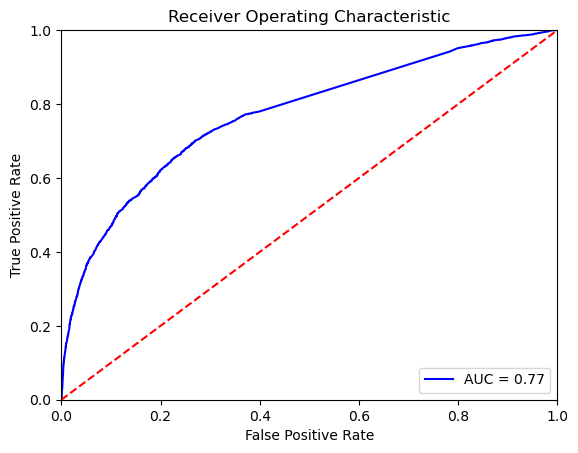

In [59]:
cat_untuned_tf = train_catboost(X_train_tf, y_train_tf)
evaluate_model(cat_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(cat_untuned_tf, "CatBoostClassifier", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 102961
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 2746
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 82.75%
------------------------------------------------
Confusion Matrix:
       0     1
0  13950   509
1   2661  1258
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.71      0.32      0.44      3919

    accuracy                           0.83  

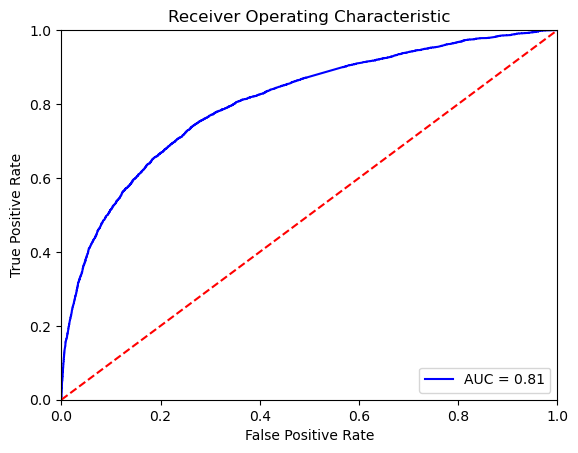

In [60]:
light_untuned_tf = train_lightgbm(X_train_tf, y_train_tf)
evaluate_model(light_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(light_untuned_tf, "LightGBM", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

model accuracy for classification is = 82.81%
------------------------------------------------
Confusion Matrix:
       0     1
0  13847   612
1   2548  1371
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     14459
           1       0.69      0.35      0.46      3919

    accuracy                           0.83     18378
   macro avg       0.77      0.65      0.68     18378
weighted avg       0.81      0.83      0.81     18378



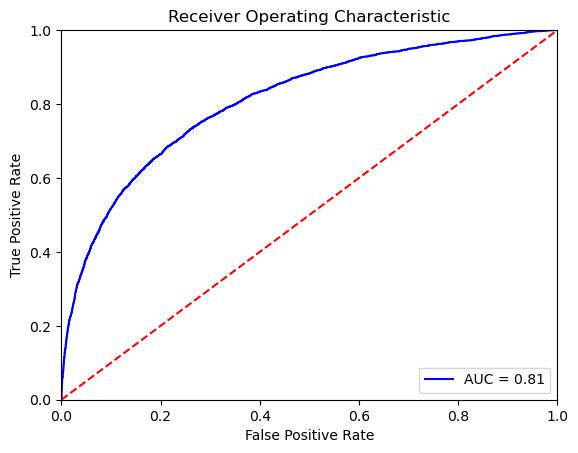

In [61]:
stack_untuned_tf = train_stacking_rf_svm(X_train_tf, y_train_tf)
evaluate_model(stack_untuned_tf, X_test_tf, y_test_tf)
add_to_eval_df(stack_untuned_tf, "StackingClassifier-RF-SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

In [62]:
svc_untuned_tf = train_svc(X_train_tf, y_train_tf)
add_to_eval_df(svc_untuned_tf, "SVC", "untuned", "tf", X_train_tf, y_train_tf, X_test_tf, y_test_tf)

#### Glove100d

model accuracy for classification is = 80.01%
------------------------------------------------
Confusion Matrix:
       0    1
0  14265  194
1   3480  439
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.69      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.75      0.55      0.54     18378
weighted avg       0.78      0.80      0.74     18378



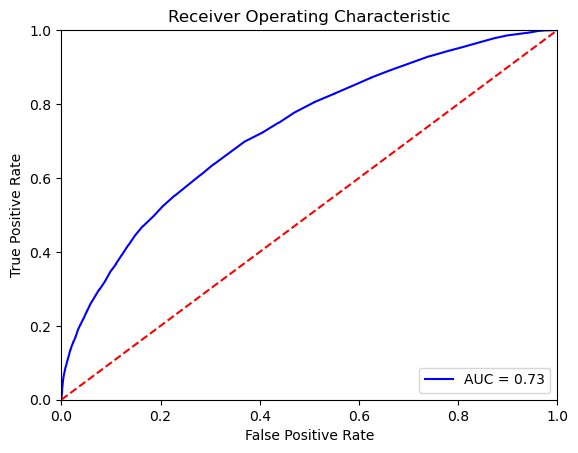

In [63]:
rf_untuned_gl = train_randomforest(X_train_gl, y_train_gl)
evaluate_model(rf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_untuned_gl, "RandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 78.98%
------------------------------------------------
Confusion Matrix:
       0    1
0  14390   69
1   3794  125
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     14459
           1       0.64      0.03      0.06      3919

    accuracy                           0.79     18378
   macro avg       0.72      0.51      0.47     18378
weighted avg       0.76      0.79      0.71     18378



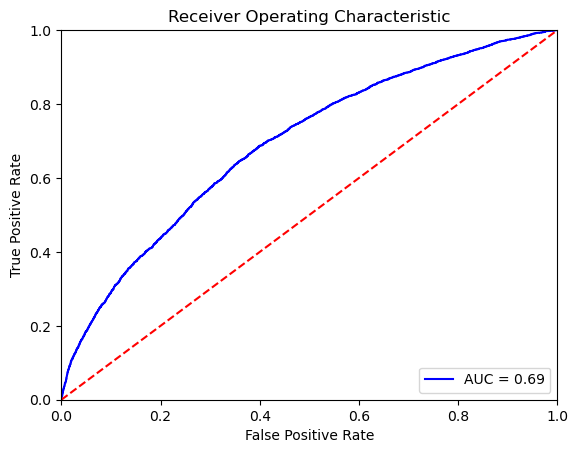

In [64]:
rf_rand_gl = train_randomforest_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(rf_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_rand_gl, "RandomForest", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.06%
------------------------------------------------
Confusion Matrix:
       0    1
0  14279  180
1   3485  434
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14459
           1       0.71      0.11      0.19      3919

    accuracy                           0.80     18378
   macro avg       0.76      0.55      0.54     18378
weighted avg       0.78      0.80      0.74     18378



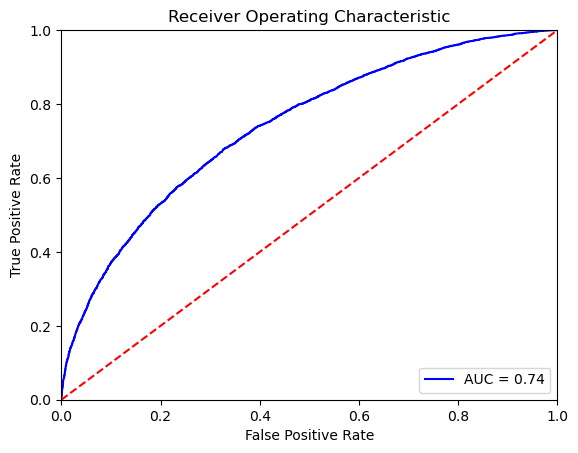

In [65]:
rf_optuna_gl = train_randomforest_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(rf_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(rf_optuna_gl, "RandomForest", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

model accuracy for classification is = 70.94%
------------------------------------------------
Confusion Matrix:
       0     1
0  10482  3977
1   1364  2555
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.80     14459
           1       0.39      0.65      0.49      3919

    accuracy                           0.71     18378
   macro avg       0.64      0.69      0.64     18378
weighted avg       0.78      0.71      0.73     18378



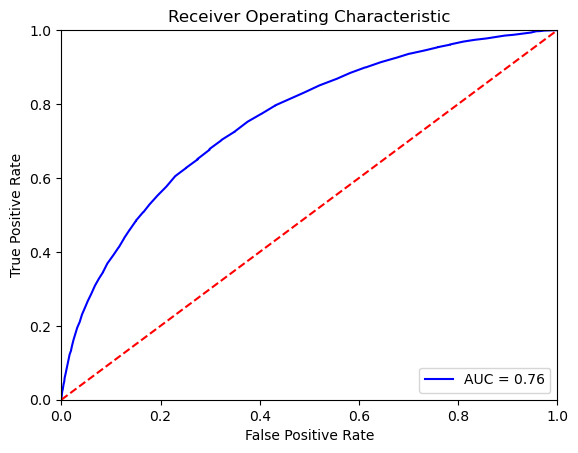

In [66]:
brf_untuned_gl = train_balancedrandomforest(X_train_gl, y_train_gl)
evaluate_model(brf_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(brf_untuned_gl, "BalancedRandomForest", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.41%
------------------------------------------------
Confusion Matrix:
       0     1
0  13642   817
1   2783  1136
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     14459
           1       0.58      0.29      0.39      3919

    accuracy                           0.80     18378
   macro avg       0.71      0.62      0.64     18378
weighted avg       0.78      0.80      0.78     18378



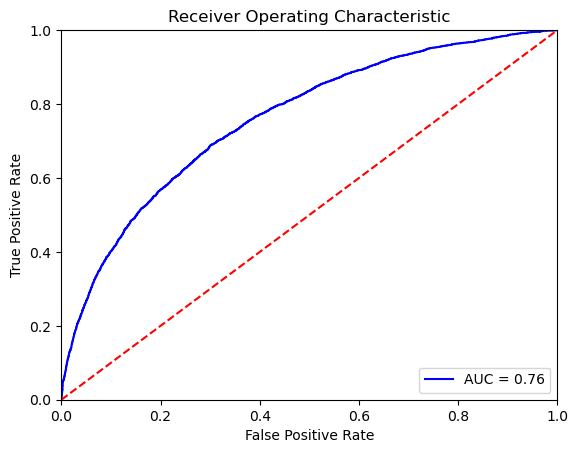

In [67]:
xgb_untuned_gl = train_xgboost(X_train_gl, y_train_gl)
evaluate_model(xgb_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_untuned_gl, "XGBoost", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 81.25%
------------------------------------------------
Confusion Matrix:
       0     1
0  13926   533
1   2912  1007
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     14459
           1       0.65      0.26      0.37      3919

    accuracy                           0.81     18378
   macro avg       0.74      0.61      0.63     18378
weighted avg       0.79      0.81      0.78     18378



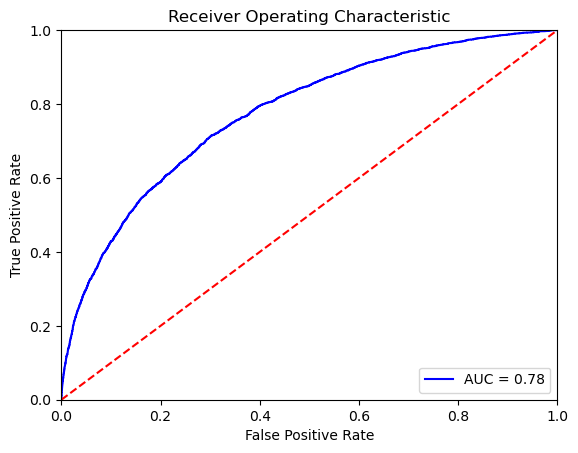

In [68]:
xgb_grid_gl = train_xgboost_tuned_gridsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_grid_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_grid_gl, "XGBoost", "gridsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 80.90%
------------------------------------------------
Confusion Matrix:
       0     1
0  13772   687
1   2824  1095
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     14459
           1       0.61      0.28      0.38      3919

    accuracy                           0.81     18378
   macro avg       0.72      0.62      0.64     18378
weighted avg       0.78      0.81      0.78     18378



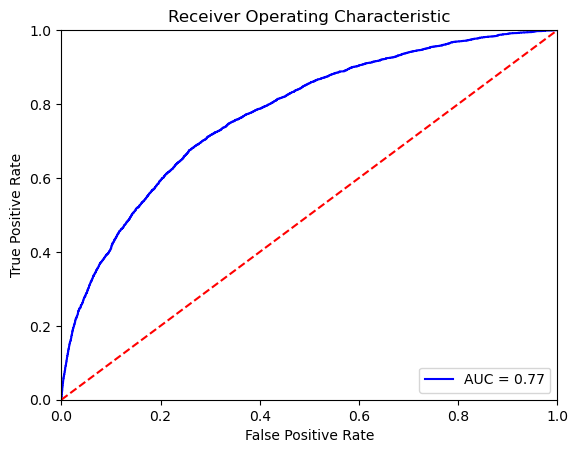

In [69]:
xgb_rand_gl = train_xgboost_tuned_randsearch(X_train_gl, y_train_gl)
evaluate_model(xgb_rand_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_rand_gl, "XGBoost", "randsearch", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:59] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "boost" } are not used.

  warnings.warn(smsg, UserWarning)


model accuracy for classification is = 79.31%
------------------------------------------------
Confusion Matrix:
       0     1
0  13340  1119
1   2684  1235
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.92      0.88     14459
           1       0.52      0.32      0.39      3919

    accuracy                           0.79     18378
   macro avg       0.68      0.62      0.63     18378
weighted avg       0.77      0.79      0.77     18378



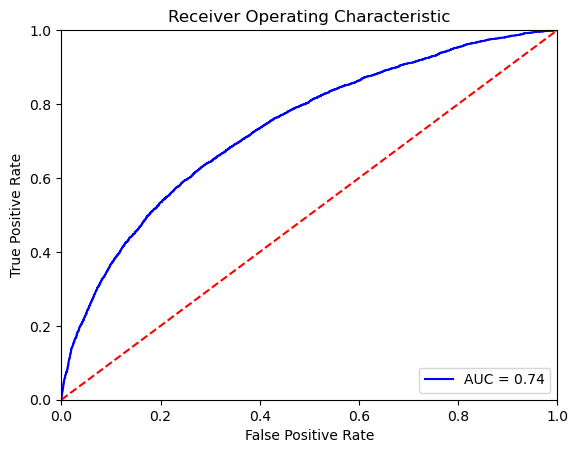

In [70]:
xgb_optuna_gl = train_xgboost_tuned_optuna(X_train_gl, y_train_gl)
evaluate_model(xgb_optuna_gl, X_test_gl, y_test_gl)
add_to_eval_df(xgb_optuna_gl, "XGBoost", "optuna", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

0:	learn: 0.6555567	total: 26.4ms	remaining: 2.61s
1:	learn: 0.6219014	total: 52.5ms	remaining: 2.57s
2:	learn: 0.5951343	total: 77.5ms	remaining: 2.51s
3:	learn: 0.5731545	total: 103ms	remaining: 2.48s
4:	learn: 0.5545928	total: 129ms	remaining: 2.45s
5:	learn: 0.5409164	total: 153ms	remaining: 2.4s
6:	learn: 0.5294704	total: 180ms	remaining: 2.39s
7:	learn: 0.5203669	total: 206ms	remaining: 2.37s
8:	learn: 0.5126102	total: 231ms	remaining: 2.33s
9:	learn: 0.5057233	total: 257ms	remaining: 2.31s
10:	learn: 0.5006708	total: 283ms	remaining: 2.29s
11:	learn: 0.4960348	total: 311ms	remaining: 2.28s
12:	learn: 0.4920602	total: 338ms	remaining: 2.26s
13:	learn: 0.4881078	total: 362ms	remaining: 2.22s
14:	learn: 0.4850348	total: 386ms	remaining: 2.19s
15:	learn: 0.4825068	total: 411ms	remaining: 2.16s
16:	learn: 0.4801479	total: 437ms	remaining: 2.13s
17:	learn: 0.4781515	total: 463ms	remaining: 2.11s
18:	learn: 0.4763184	total: 488ms	remaining: 2.08s
19:	learn: 0.4746670	total: 514ms	remai

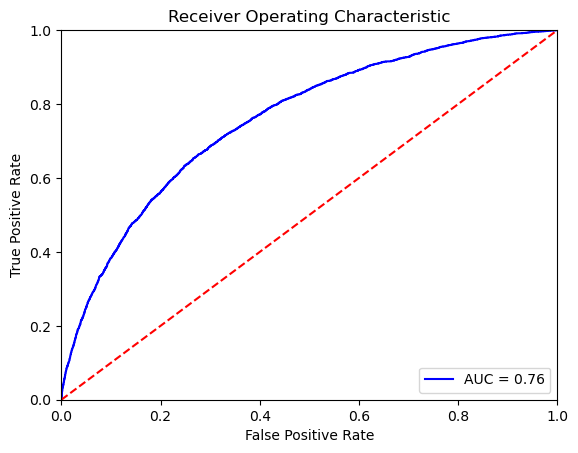

In [71]:
cat_untuned_gl = train_catboost(X_train_gl, y_train_gl)
evaluate_model(cat_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(cat_untuned_gl, "CatBoostClassifier", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

[LightGBM] [Info] Number of positive: 9184, number of negative: 33695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 42879, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214184 -> initscore=-1.299887
[LightGBM] [Info] Start training from score -1.299887
model accuracy for classification is = 80.69%
------------------------------------------------
Confusion Matrix:
       0    1
0  13933  526
1   3022  897
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     14459
           1       0.63      0.23      0.34      3919

    accuracy                           0.81     18378
   macro avg       0.73      0.60      0.61     18378
weight

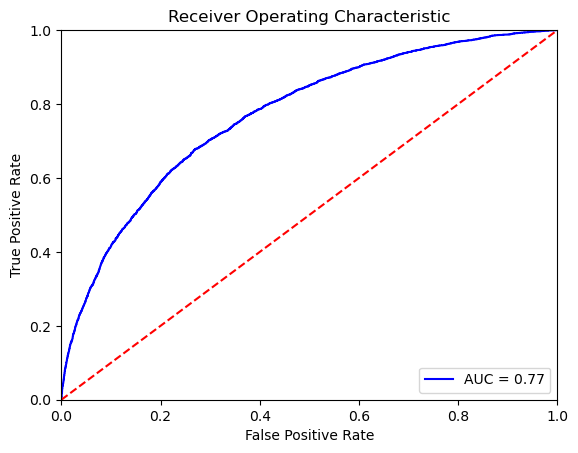

In [72]:
light_untuned_gl = train_lightgbm(X_train_gl, y_train_gl)
evaluate_model(light_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(light_untuned_gl, "LightGBM", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

model accuracy for classification is = 79.82%
------------------------------------------------
Confusion Matrix:
       0    1
0  13946  513
1   3195  724
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     14459
           1       0.59      0.18      0.28      3919

    accuracy                           0.80     18378
   macro avg       0.70      0.57      0.58     18378
weighted avg       0.76      0.80      0.75     18378



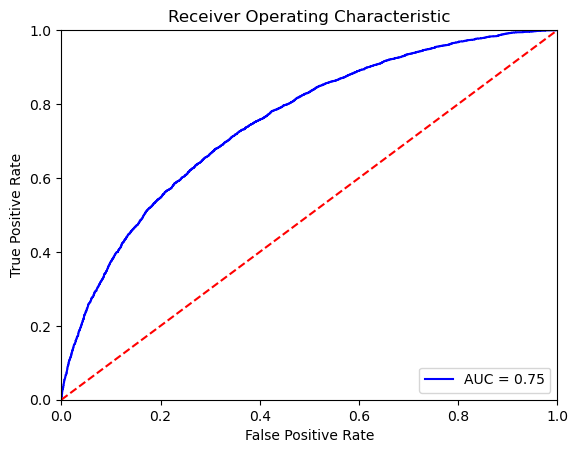

In [73]:
stack_untuned_gl = train_stacking_rf_svm(X_train_gl, y_train_gl)
evaluate_model(stack_untuned_gl, X_test_gl, y_test_gl)
add_to_eval_df(stack_untuned_gl, "StackingClassifier-RF-SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

In [74]:
svc_untuned_gl = train_svc(X_train_gl, y_train_gl)
add_to_eval_df(svc_untuned_gl, "SVC", "untuned", "glove", X_train_gl, y_train_gl, X_test_gl, y_test_gl)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Model evaluation

In [75]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,tuning,vec_variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
15,BalancedRandomForest,untuned,tf,0.882693,0.646165,0.999782,0.784988,0.744695,0.439113,0.712171,0.543260
27,BalancedRandomForest,untuned,glove,0.913734,0.712910,0.999891,0.832359,0.709381,0.391151,0.651952,0.488948
23,SVC,untuned,tf,0.874671,0.818775,0.532774,0.645515,0.817717,0.616646,0.383771,0.473105
3,BalancedRandomForest,untuned,w2v,0.891042,0.662818,1.000000,0.797222,0.683154,0.363336,0.645828,0.465044
22,StackingClassifier-RF-SVC,untuned,tf,0.984468,0.986298,0.940549,0.962880,0.828055,0.691377,0.349834,0.464588
17,XGBoost,gridsearch,tf,0.859815,0.866991,0.408101,0.554971,0.829089,0.710043,0.335545,0.455727
19,XGBoost,optuna,tf,0.842230,0.781869,0.365309,0.497959,0.826042,0.691005,0.333248,0.449647
21,LightGBM,untuned,tf,0.843653,0.807387,0.354639,0.492813,0.827511,0.711941,0.321000,0.442490
16,XGBoost,untuned,tf,0.848061,0.842619,0.357361,0.501873,0.827729,0.724776,0.309773,0.434036
18,XGBoost,randsearch,tf,0.836936,0.801928,0.316964,0.454347,0.825988,0.724611,0.296759,0.421072


#### Test models on old data

In [76]:
df_train_old_cleaned = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train_cleaned.csv")
df_train_old_cleaned = df_train_old_cleaned[df_train_old_cleaned.tweet_cleaned.notna()]

In [77]:
X_data = df_train_old_cleaned["tweet_cleaned"]
y_data = df_train_old_cleaned["label"]


X_data_vectorized = tf_model.transform(X_data)

model accuracy for classification is = 89.40%
------------------------------------------------
Confusion Matrix:
       0     1
0  17212  1109
1    971   333
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     18321
           1       0.23      0.26      0.24      1304

    accuracy                           0.89     19625
   macro avg       0.59      0.60      0.59     19625
weighted avg       0.90      0.89      0.90     19625



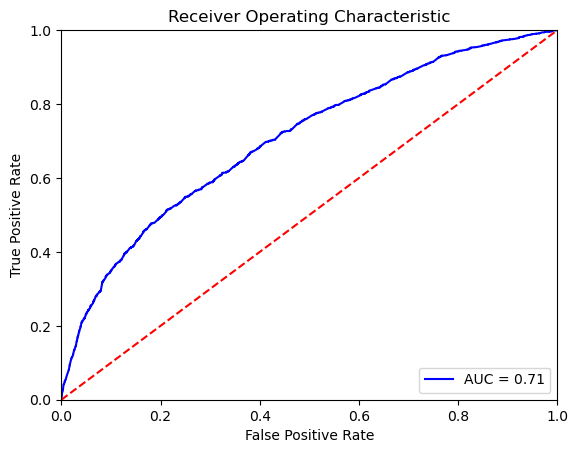

In [78]:
evaluate_model(brf_untuned_tf, X_data_vectorized, y_data)